In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


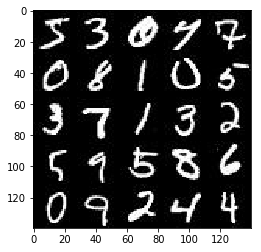

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

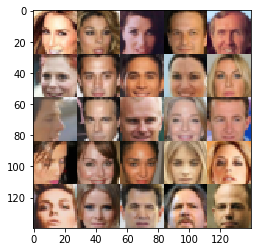

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
alpha = 0.15
padding = 'same'
initializer = tf.contrib.layers.xavier_initializer_conv2d()

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):        
        conv1 = tf.layers.conv2d(images, 64, 5, 2, padding=padding, kernel_initializer=initializer)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 128, 5, 2, padding=padding, kernel_initializer=initializer)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        #conv2 = tf.layers.dropout(conv2, rate=0.2, training=True)
        
        conv3 = tf.layers.conv2d(conv2, 256, 5, 2, padding=padding, kernel_initializer=initializer)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        #conv3 = tf.layers.dropout(conv3, rate=0.2, training=True)
        
        flat   = tf.reshape(conv3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse=not(is_train)):        
        h1 = tf.layers.dense(z, 7*7*256)
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        h1 = tf.layers.batch_normalization(h1, training=is_train)
        h1 =tf.maximum(alpha * h1, h1) #leaky_relu
    
        h2 = tf.layers.conv2d_transpose(h1, 128, 5, strides=2, kernel_initializer=initializer, padding=padding)
        h2 = tf.layers.batch_normalization(h2, training=is_train)
        h2 = tf.maximum(alpha * h2, h2) #leaky_relu
        #h2 = tf.layers.dropout(h2, rate=0.2, training=is_train)
    
        h3 = tf.layers.conv2d_transpose(h2, 64, 5, strides=2, kernel_initializer=initializer, padding=padding)
        h3 = tf.layers.batch_normalization(h3, training=is_train)
        h3 = tf.maximum(alpha * h3, h3) #leaky_relu
        #h3 = tf.layers.dropout(h3, rate=0.2,training=is_train)
        
        logits = tf.layers.conv2d_transpose(h3, out_channel_dim, 3, strides=1, kernel_initializer=initializer, padding=padding)
        output = tf.tanh(logits)
 
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)
    
    d_loss_real = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function      
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)    
    with tf.control_dependencies(update_ops):
        
        # Get the trainable_variables, split into G and D parts
        t_vars = tf.trainable_variables()
        g_vars = []
        d_vars = []
        for var in t_vars:
            if(var.name.startswith('generator')):
                g_vars.append(var)
            elif var.name.startswith('discriminator'):
                d_vars.append(var)

        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)       
        d_updates = []
        g_updates = []        
        for opt in update_ops:
            if opt.name.startswith('generator'):
                g_updates.append(opt)
            elif opt.name.startswith('discriminator'):
                d_updates.append(opt)            
                
        with tf.control_dependencies(g_updates):
            d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
        with tf.control_dependencies(g_updates):
            g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt            


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

__Hyper Parameters__

In [12]:
steps = 100
print_every = 100
show_every = 100
losses = []
n_images = 25

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model                
    img_width    = data_shape[1]
    img_height   = data_shape[2]
    img_channels = data_shape[3]
        
    #Input
    input_real, input_z, tf_placeholder_learning_rate = model_inputs(img_width, img_height, img_channels, z_dim)
    
    #Loss
    d_loss, g_loss = model_loss(input_real, input_z, img_channels)
    
    #Optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
      
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images * 2
                steps = steps + 1
                
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                # Run optimizers               
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
  
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps == 1:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)                                                                   
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_channels, data_image_mode)  
                    
    print("Finished")

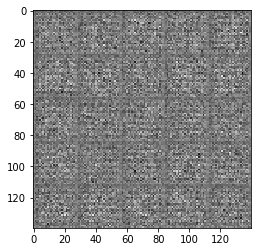

Epoch 1/2... Discriminator Loss: 2.0515... Generator Loss: 0.2271


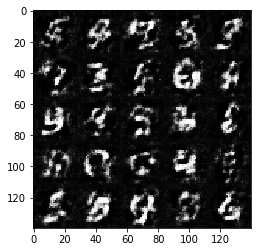

Epoch 1/2... Discriminator Loss: 1.6226... Generator Loss: 0.4544


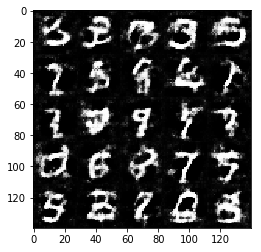

Epoch 1/2... Discriminator Loss: 1.7489... Generator Loss: 0.3583


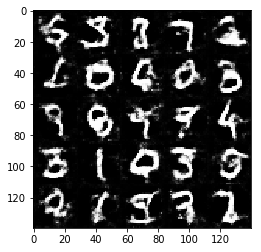

Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 0.4056


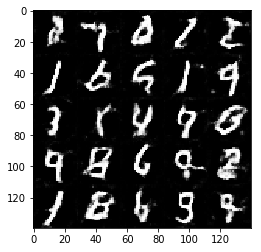

Epoch 1/2... Discriminator Loss: 1.7076... Generator Loss: 0.3276


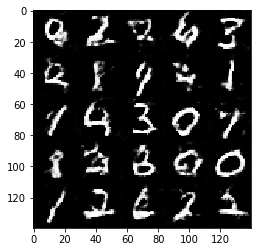

Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.5002


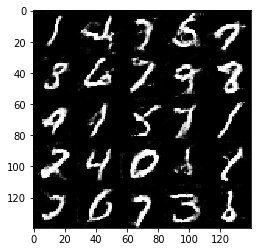

Epoch 1/2... Discriminator Loss: 1.6150... Generator Loss: 0.4186


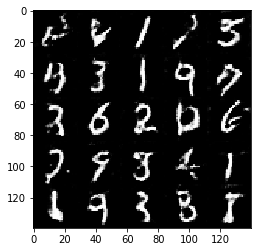

Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.4850


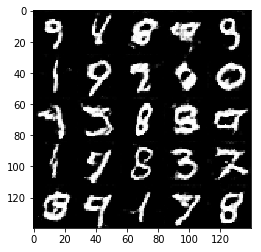

Epoch 1/2... Discriminator Loss: 1.2724... Generator Loss: 0.7098


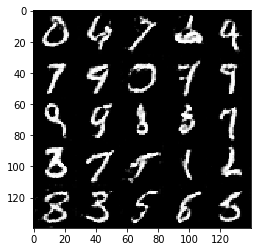

Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.5728


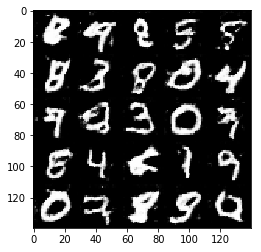

Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.5616


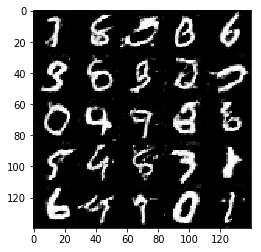

Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.5286


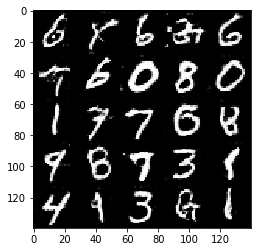

Epoch 2/2... Discriminator Loss: 1.4382... Generator Loss: 0.4832


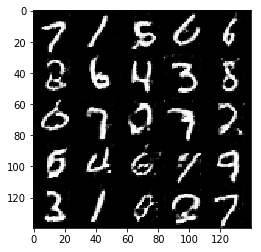

Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.5973


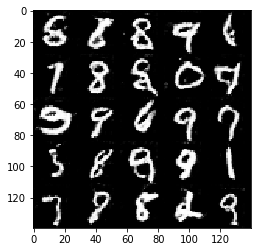

Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 1.0822


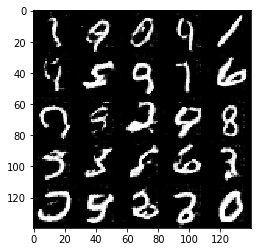

Epoch 2/2... Discriminator Loss: 1.0226... Generator Loss: 1.3174


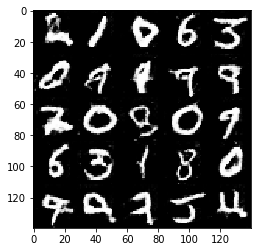

Epoch 2/2... Discriminator Loss: 1.2780... Generator Loss: 0.6402


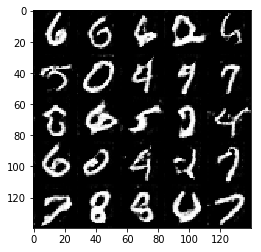

Epoch 2/2... Discriminator Loss: 1.3155... Generator Loss: 0.6321


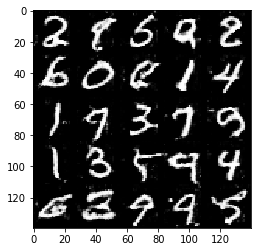

Finished


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs,
          batch_size, 
          z_dim,
          learning_rate,
          beta1, 
          mnist_dataset.get_batches,
          mnist_dataset.shape,
          mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

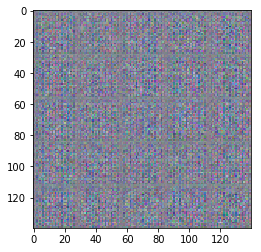

Epoch 1/1... Discriminator Loss: 2.8184... Generator Loss: 0.0956


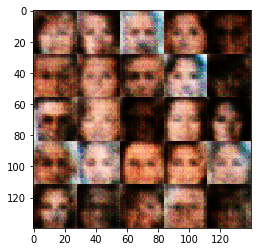

Epoch 1/1... Discriminator Loss: 2.4136... Generator Loss: 0.1704


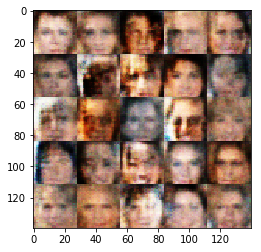

Epoch 1/1... Discriminator Loss: 1.9101... Generator Loss: 0.2834


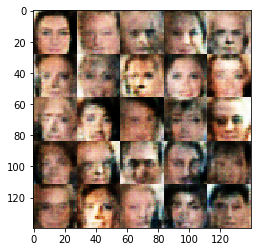

Epoch 1/1... Discriminator Loss: 2.1842... Generator Loss: 0.1936


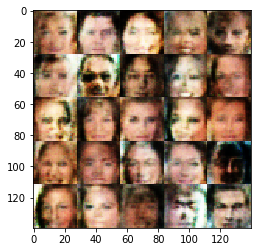

Epoch 1/1... Discriminator Loss: 2.2854... Generator Loss: 0.1834


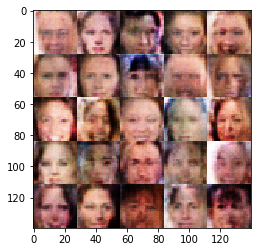

Epoch 1/1... Discriminator Loss: 2.0796... Generator Loss: 0.2400


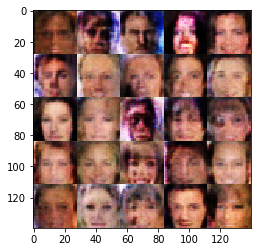

Epoch 1/1... Discriminator Loss: 2.1155... Generator Loss: 0.2228


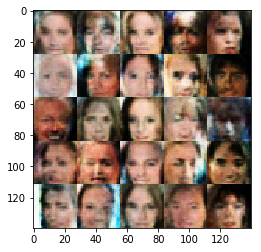

Epoch 1/1... Discriminator Loss: 2.6338... Generator Loss: 0.1193


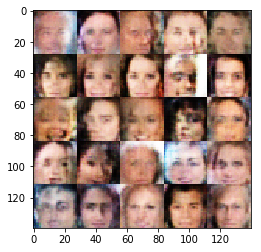

Epoch 1/1... Discriminator Loss: 1.9606... Generator Loss: 0.2452


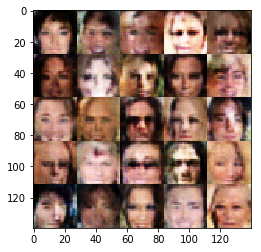

Epoch 1/1... Discriminator Loss: 1.8988... Generator Loss: 0.2723


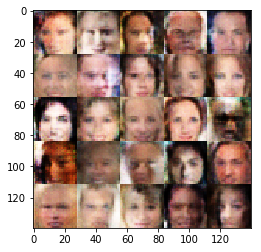

Epoch 1/1... Discriminator Loss: 2.4658... Generator Loss: 0.1380


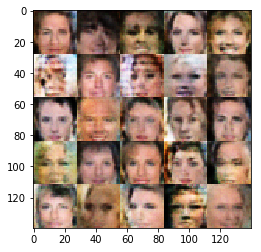

Epoch 1/1... Discriminator Loss: 2.4900... Generator Loss: 0.1547


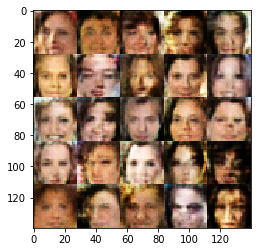

Epoch 1/1... Discriminator Loss: 2.5155... Generator Loss: 0.1387


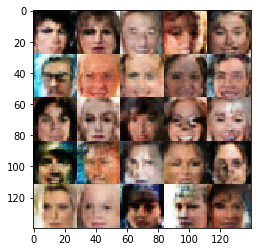

Epoch 1/1... Discriminator Loss: 2.2268... Generator Loss: 0.1852


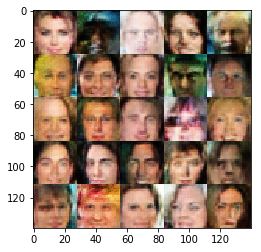

Epoch 1/1... Discriminator Loss: 2.2159... Generator Loss: 0.2066


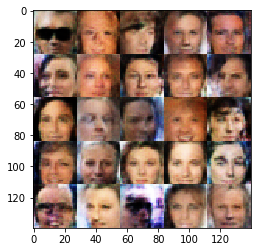

Epoch 1/1... Discriminator Loss: 2.5783... Generator Loss: 0.1346


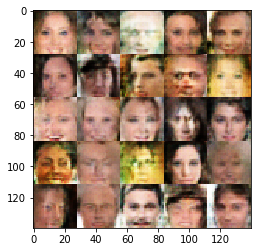

Epoch 1/1... Discriminator Loss: 2.4624... Generator Loss: 0.1387


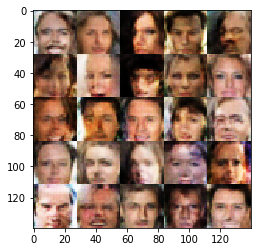

Epoch 1/1... Discriminator Loss: 2.4393... Generator Loss: 0.1408


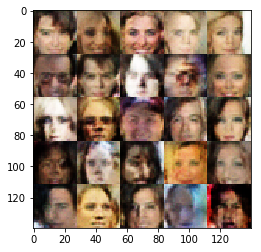

Epoch 1/1... Discriminator Loss: 2.3873... Generator Loss: 0.1542


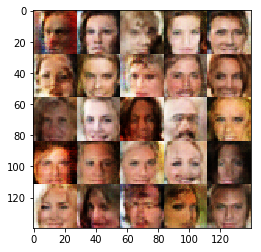

Epoch 1/1... Discriminator Loss: 2.5627... Generator Loss: 0.1299


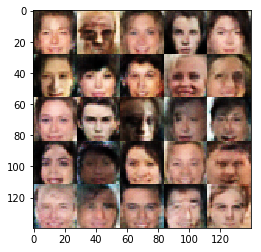

Epoch 1/1... Discriminator Loss: 2.3208... Generator Loss: 0.1594


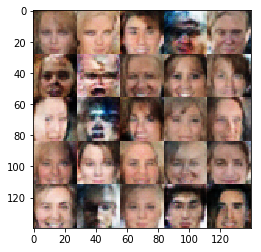

Epoch 1/1... Discriminator Loss: 2.5710... Generator Loss: 0.1244


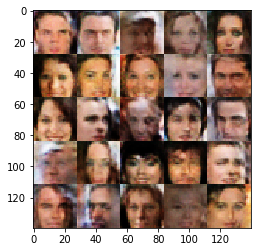

Epoch 1/1... Discriminator Loss: 2.5117... Generator Loss: 0.1338


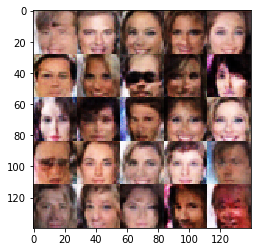

Epoch 1/1... Discriminator Loss: 2.3600... Generator Loss: 0.1485


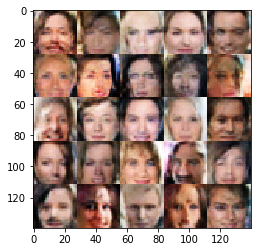

Epoch 1/1... Discriminator Loss: 2.7581... Generator Loss: 0.1042


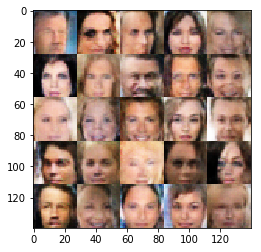

Epoch 1/1... Discriminator Loss: 2.6474... Generator Loss: 0.1166


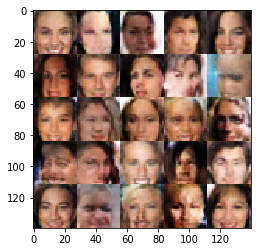

Epoch 1/1... Discriminator Loss: 2.3316... Generator Loss: 0.1624


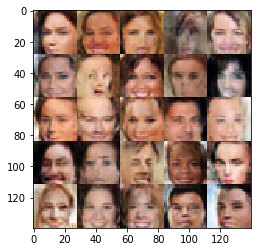

Epoch 1/1... Discriminator Loss: 2.4146... Generator Loss: 0.1506


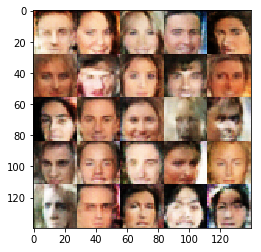

Epoch 1/1... Discriminator Loss: 2.2226... Generator Loss: 0.1875


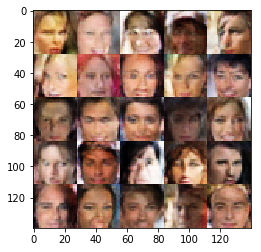

Epoch 1/1... Discriminator Loss: 2.5655... Generator Loss: 0.1234


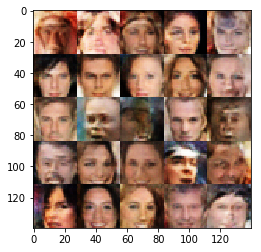

Epoch 1/1... Discriminator Loss: 2.5041... Generator Loss: 0.1334


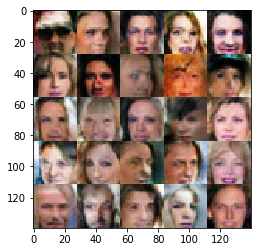

Epoch 1/1... Discriminator Loss: 2.3639... Generator Loss: 0.1501


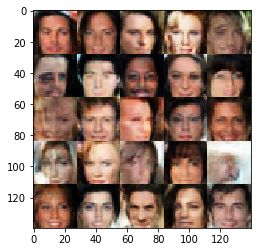

Epoch 1/1... Discriminator Loss: 2.6892... Generator Loss: 0.1149


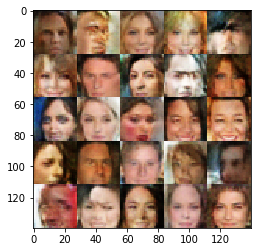

Epoch 1/1... Discriminator Loss: 2.2332... Generator Loss: 0.1766


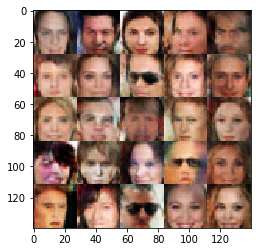

Epoch 1/1... Discriminator Loss: 2.6845... Generator Loss: 0.1159


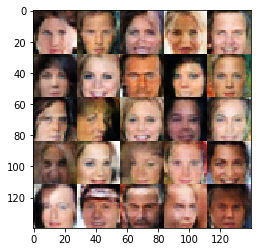

Epoch 1/1... Discriminator Loss: 2.4753... Generator Loss: 0.1370


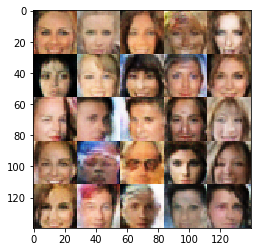

Epoch 1/1... Discriminator Loss: 2.7998... Generator Loss: 0.0968


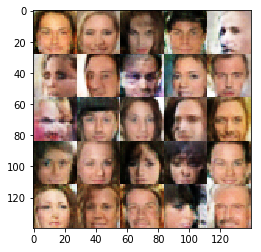

Epoch 1/1... Discriminator Loss: 2.3872... Generator Loss: 0.1477


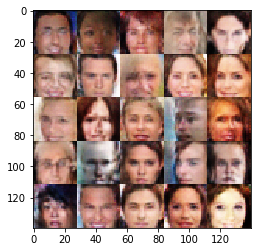

Epoch 1/1... Discriminator Loss: 2.3896... Generator Loss: 0.1425


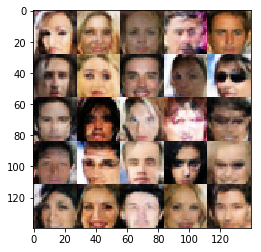

Epoch 1/1... Discriminator Loss: 2.5029... Generator Loss: 0.1360


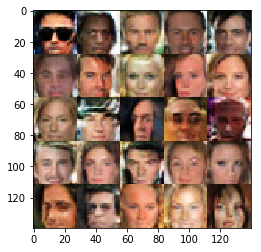

Epoch 1/1... Discriminator Loss: 2.3551... Generator Loss: 0.1687


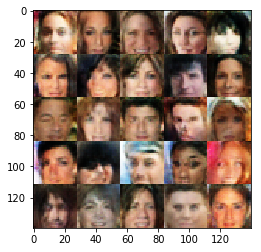

Epoch 1/1... Discriminator Loss: 2.4181... Generator Loss: 0.1452


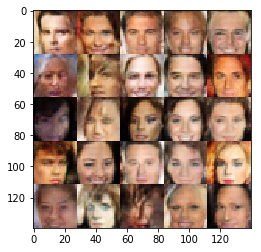

Epoch 1/1... Discriminator Loss: 2.4632... Generator Loss: 0.1502


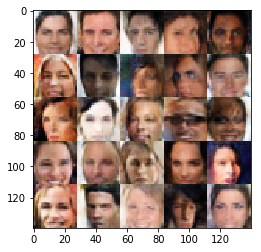

Epoch 1/1... Discriminator Loss: 2.9322... Generator Loss: 0.0926


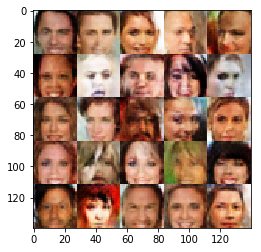

Epoch 1/1... Discriminator Loss: 2.1564... Generator Loss: 0.2019


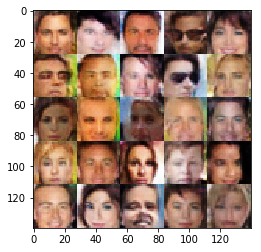

Epoch 1/1... Discriminator Loss: 2.2135... Generator Loss: 0.1960


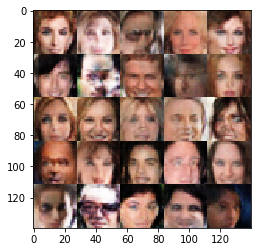

Epoch 1/1... Discriminator Loss: 2.5705... Generator Loss: 0.1259


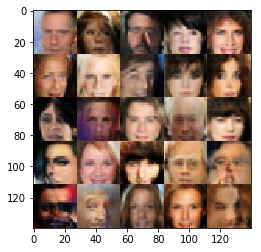

Epoch 1/1... Discriminator Loss: 2.5160... Generator Loss: 0.1366


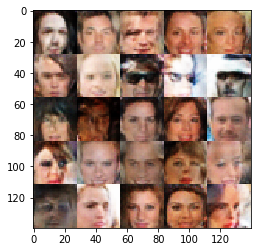

Epoch 1/1... Discriminator Loss: 2.4079... Generator Loss: 0.1604


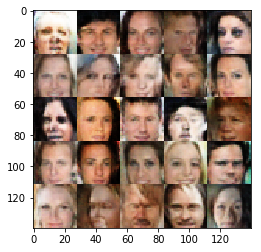

Epoch 1/1... Discriminator Loss: 2.7706... Generator Loss: 0.1723


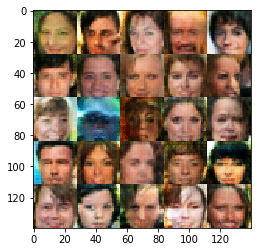

Epoch 1/1... Discriminator Loss: 2.4385... Generator Loss: 0.1596


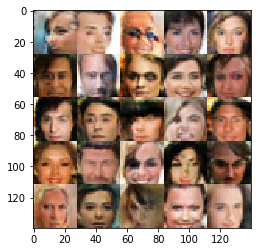

Epoch 1/1... Discriminator Loss: 2.6421... Generator Loss: 0.1181


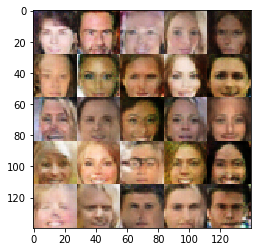

Epoch 1/1... Discriminator Loss: 2.3029... Generator Loss: 0.1725


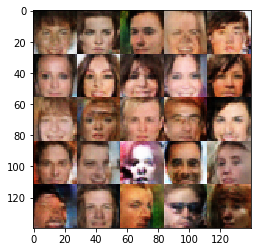

Epoch 1/1... Discriminator Loss: 2.3516... Generator Loss: 0.1538


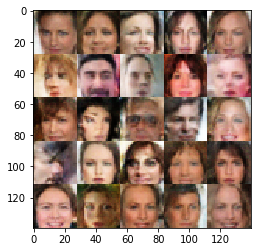

Epoch 1/1... Discriminator Loss: 2.1036... Generator Loss: 0.2181


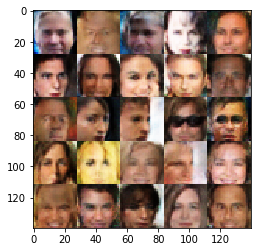

Epoch 1/1... Discriminator Loss: 2.5704... Generator Loss: 0.1438


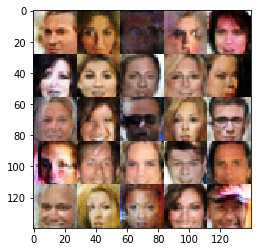

Epoch 1/1... Discriminator Loss: 2.5654... Generator Loss: 0.1253


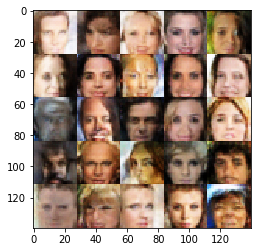

Epoch 1/1... Discriminator Loss: 2.1059... Generator Loss: 0.2239


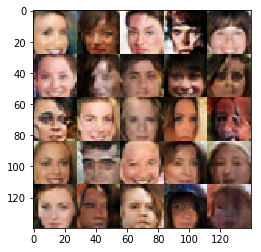

Epoch 1/1... Discriminator Loss: 2.8946... Generator Loss: 0.0916


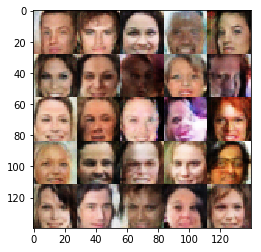

Epoch 1/1... Discriminator Loss: 2.6779... Generator Loss: 0.1238


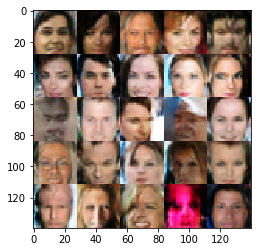

Epoch 1/1... Discriminator Loss: 2.2475... Generator Loss: 0.1744


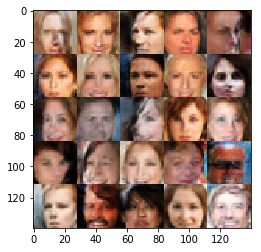

Epoch 1/1... Discriminator Loss: 2.6489... Generator Loss: 0.1138


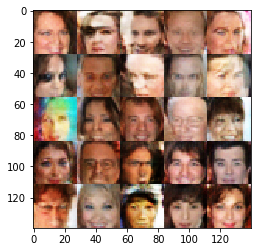

Epoch 1/1... Discriminator Loss: 2.3676... Generator Loss: 0.1671


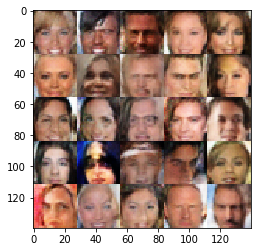

Finished


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.